In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split


## data creation

In [3]:
# Load the training and testing datasets
fusion = pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-chatgpt-fusion.xlsx")
human=pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-init.xlsx")
polish=pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-chatgpt-polish.xlsx")
generated=pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-chatgpt-generation.xlsx")
# test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")


In [4]:
fusion.head()

,Unnamed: 0,index,id,title,keyword,abstract
0,0,0,8600003,An Improved Variable-Node-Based BP Decoding Al...,"""Flash memories"",""Reliability"",""Decoding"",""Par...",To solve the problems of the data reliability ...
1,1,1,8600004,Mobile Robot Location Algorithm Based on Impro...,"""Sociology"",""Statistics"",""Simultaneous localiz...",Many techniques have been proposed to solve th...
2,2,2,8600008,Vertical Handoff Decision Algorithm for Hetero...,"""Entropy"",""Handover"",""Wireless networks"",""Deci...",In the future scenario of multiple wireless ne...
3,3,3,8600013,Robust offline trained neural network for TDOA...,"""Microphones"",""Artificial neural networks"",""Po...",Passive sound source localization using time-d...
4,4,6,8600029,A Social Bots Detection Model Based on Deep Le...,"""Feature extraction"",""Metadata"",""Detection alg...","With the development of the Internet, social b..."


In [5]:
fusion['final_text']=fusion['title']+" "+fusion['abstract']
human['final_text']=human['title']+" "+human['abstract']
generated['final_text']=generated['title']+" "+generated['abstract']
polish['final_text']=polish['title']+" "+polish['abstract']


In [6]:
human   = human.assign(label=0)
# polish  = polish.assign(label=1)
# fusion  = fusion.assign(label=2)
generated = generated.assign(label=1)

# 2. Concatenate human and generated
merged = pd.concat(
    [human, generated],
    ignore_index=True
)

# 3. Keep only the two columns you need
merged = merged[['final_text', 'label']]

# 4. Export to CSV
merged.to_csv('merged_dataset.csv', index=False)

In [7]:
balanced = (
    merged
    .groupby('label', group_keys=False)
    .sample(n=2000, random_state=42)
    .reset_index(drop=True)
)

## preprocessing

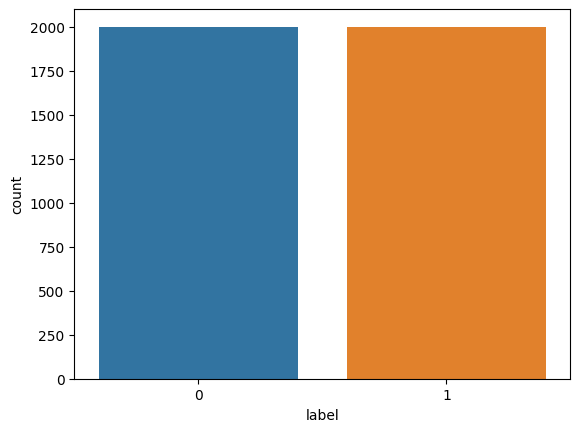

In [8]:
# Check for class balance
sns.countplot(data=balanced, x='label')
plt.show()


In [9]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

balanced['clean_text'] = balanced['final_text'].apply(clean_text)

In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(balanced['clean_text'], balanced['label'], test_size=0.2, random_state=42)


<Axes: xlabel='label', ylabel='count'>

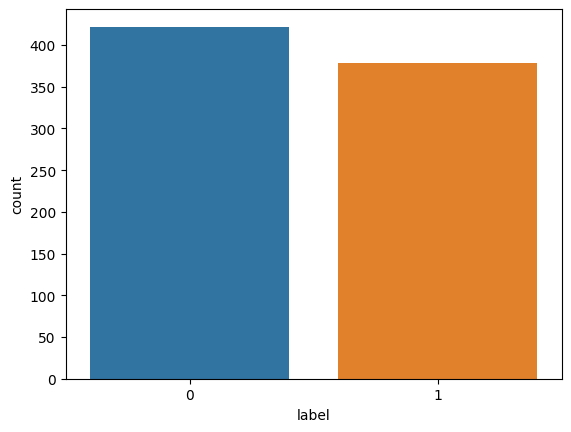

In [11]:
sns.countplot(x=y_val)

In [13]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

# Paste your HF token here as a string:
login(token=secret_value_0)


In [14]:
# 1) Make sure transformers is installed/upgraded:
#    pip install --upgrade transformers huggingface-hub

from transformers import BertTokenizer, AutoTokenizer

try:
    # Try the direct BertTokenizer
    tokenizer = BertTokenizer.from_pretrained(
        "bert-base-uncased",
        do_lower_case=True,
        padding=True,
        truncation=True,
        max_length=128
    )
except OSError:
    # Fallback to AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        "bert-base-uncased",
        use_auth_token=True,   # if private
        do_lower_case=True,
        padding=True,
        truncation=True,
        max_length=128
    )

# Now you can tokenise:
example = "Hello, Transformers!"
enc = tokenizer(example, return_tensors="pt")
print(enc)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': tensor([[  101,  7592,  1010, 19081,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [15]:
# Tokenization and Encoding for BERTpip install --upgrade transformers huggingface-hub

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)


In [16]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')


In [17]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)


In [18]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)


In [19]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [20]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [21]:
from transformers import BertForSequenceClassification
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4
)

# Move model to device
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5

In [24]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")


Epoch 1/5, Average Training Loss: 0.28
Epoch 2/5, Average Training Loss: 0.08
Epoch 3/5, Average Training Loss: 0.02
Epoch 4/5, Average Training Loss: 0.01
Epoch 5/5, Average Training Loss: 0.00


In [25]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


In [26]:
# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 0.97
